# Variance Threshold

In [5]:
features = ['srcip', 'sport', 'dstip', 'dsport',
            'proto', 'state', 'dur', 'sbytes',
            'dbytes', 'sttl', 'dttl', 'sloss',
            'dloss', 'service',	'Sload', 'Dload',
            'Spkts', 'Dpkts', 'swin', 'dwin',
            'stcpb', 'dtcpb', 'smeansz', 'dmeansz',
            'trans_depth', 'res_bdy_len', 'Sjit', 'Djit',
            'Stime', 'Ltime', 'Sintpkt', 'Dintpkt',	'tcprtt',
            'synack', 'ackdat',	'is_sm_ips_ports', 'ct_state_ttl',
            'ct_flw_http_mthd',	'is_ftp_login',	'ct_ftp_cmd', 'ct_srv_src',
            'ct_srv_dst', 'ct_dst_ltm',	'ct_src_ ltm', 'ct_src_dport_ltm',
            'ct_dst_sport_ltm',	'ct_dst_src_ltm', 'attack_cat',	'Label']

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scripts import preprocess as ref

ORIGINAL_CSV = '../data/UNSW-NB15-BALANCED-TRAIN.csv'

origin = pd.read_csv(ORIGINAL_CSV, encoding='ISO-8859-1', low_memory=False)
df = ref.preprocess_data(origin)

df['srcip'] = pd.factorize(df['srcip'])[0]
df['dstip'] = pd.factorize(df['dstip'])[0]

X = df.drop(['attack_cat', 'Label'], axis=1)
y = df['Label']

# Train model with 30% of data will be used as a test model
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=42)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449796 entries, 0 to 449795
Data columns (total 49 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   srcip             449796 non-null  int64  
 1   sport             449796 non-null  int64  
 2   dstip             449796 non-null  int64  
 3   dsport            449796 non-null  int64  
 4   proto             449796 non-null  int64  
 5   state             449796 non-null  int64  
 6   dur               449796 non-null  float64
 7   sbytes            449796 non-null  int64  
 8   dbytes            449796 non-null  int64  
 9   sttl              449796 non-null  int64  
 10  dttl              449796 non-null  int64  
 11  sloss             449796 non-null  int64  
 12  dloss             449796 non-null  int64  
 13  service           449796 non-null  int64  
 14  Sload             449796 non-null  float64
 15  Dload             449796 non-null  float64
 16  Spkts             44

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

# Initial classifier
gbc = GradientBoostingClassifier(max_depth=5, random_state=42)

# Train classifier using all features
gbc.fit(X_train, y_train)

# train set accuracy
score_train_pre = gbc.score(X_train, y_train)
print('{:.3f}'.format(score_train_pre))

# general accuracy
score_test_pre2 = gbc.score(X_test, y_test)
print('{:.3f}'.format(score_test_pre2))

# Make predictions
preds = gbc.predict(X_test)

# Evaluate the model using the F1-score
f1_score_all = round(f1_score(y_test, preds, average='weighted'), 3)

# This f1-score we need to be beat
print(f1_score_all)

0.993
0.993
0.993


# Variance Threshold

In [8]:
# make a copy of test and train set
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = \
    X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

# Calculate the variance of each feature
# Note: if`` a feature has a variance of 0, then it's likely NOT predic``tive
X_train_v1.var(axis=0)

srcip               0.000000e+00
sport               4.838288e+08
dstip               0.000000e+00
dsport              1.845526e+12
proto               1.571787e+02
state               4.957969e-01
dur                 2.610338e+02
sbytes              1.299171e+10
dbytes              2.130795e+10
sttl                1.195395e+04
dttl                5.179673e+03
sloss               1.888080e+03
dloss               2.748612e+03
service             2.137470e+00
Sload               1.954879e+16
Dload               1.171716e+13
Spkts               9.949320e+03
Dpkts               1.241483e+04
swin                1.578954e+04
dwin                1.578138e+04
stcpb               1.767046e+18
dtcpb               1.757814e+18
smeansz             2.421121e+04
dmeansz             8.863329e+04
trans_depth         1.234545e-01
res_bdy_len         2.322931e+09
Sjit                6.549883e+08
Djit                8.791285e+06
Stime               1.049001e+12
Ltime               1.049001e+12
Sintpkt   

##### Since each data has not same scale, we need to change it to uniform scale

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_X_train_v1 = scaler.fit_transform(X_train_v1)

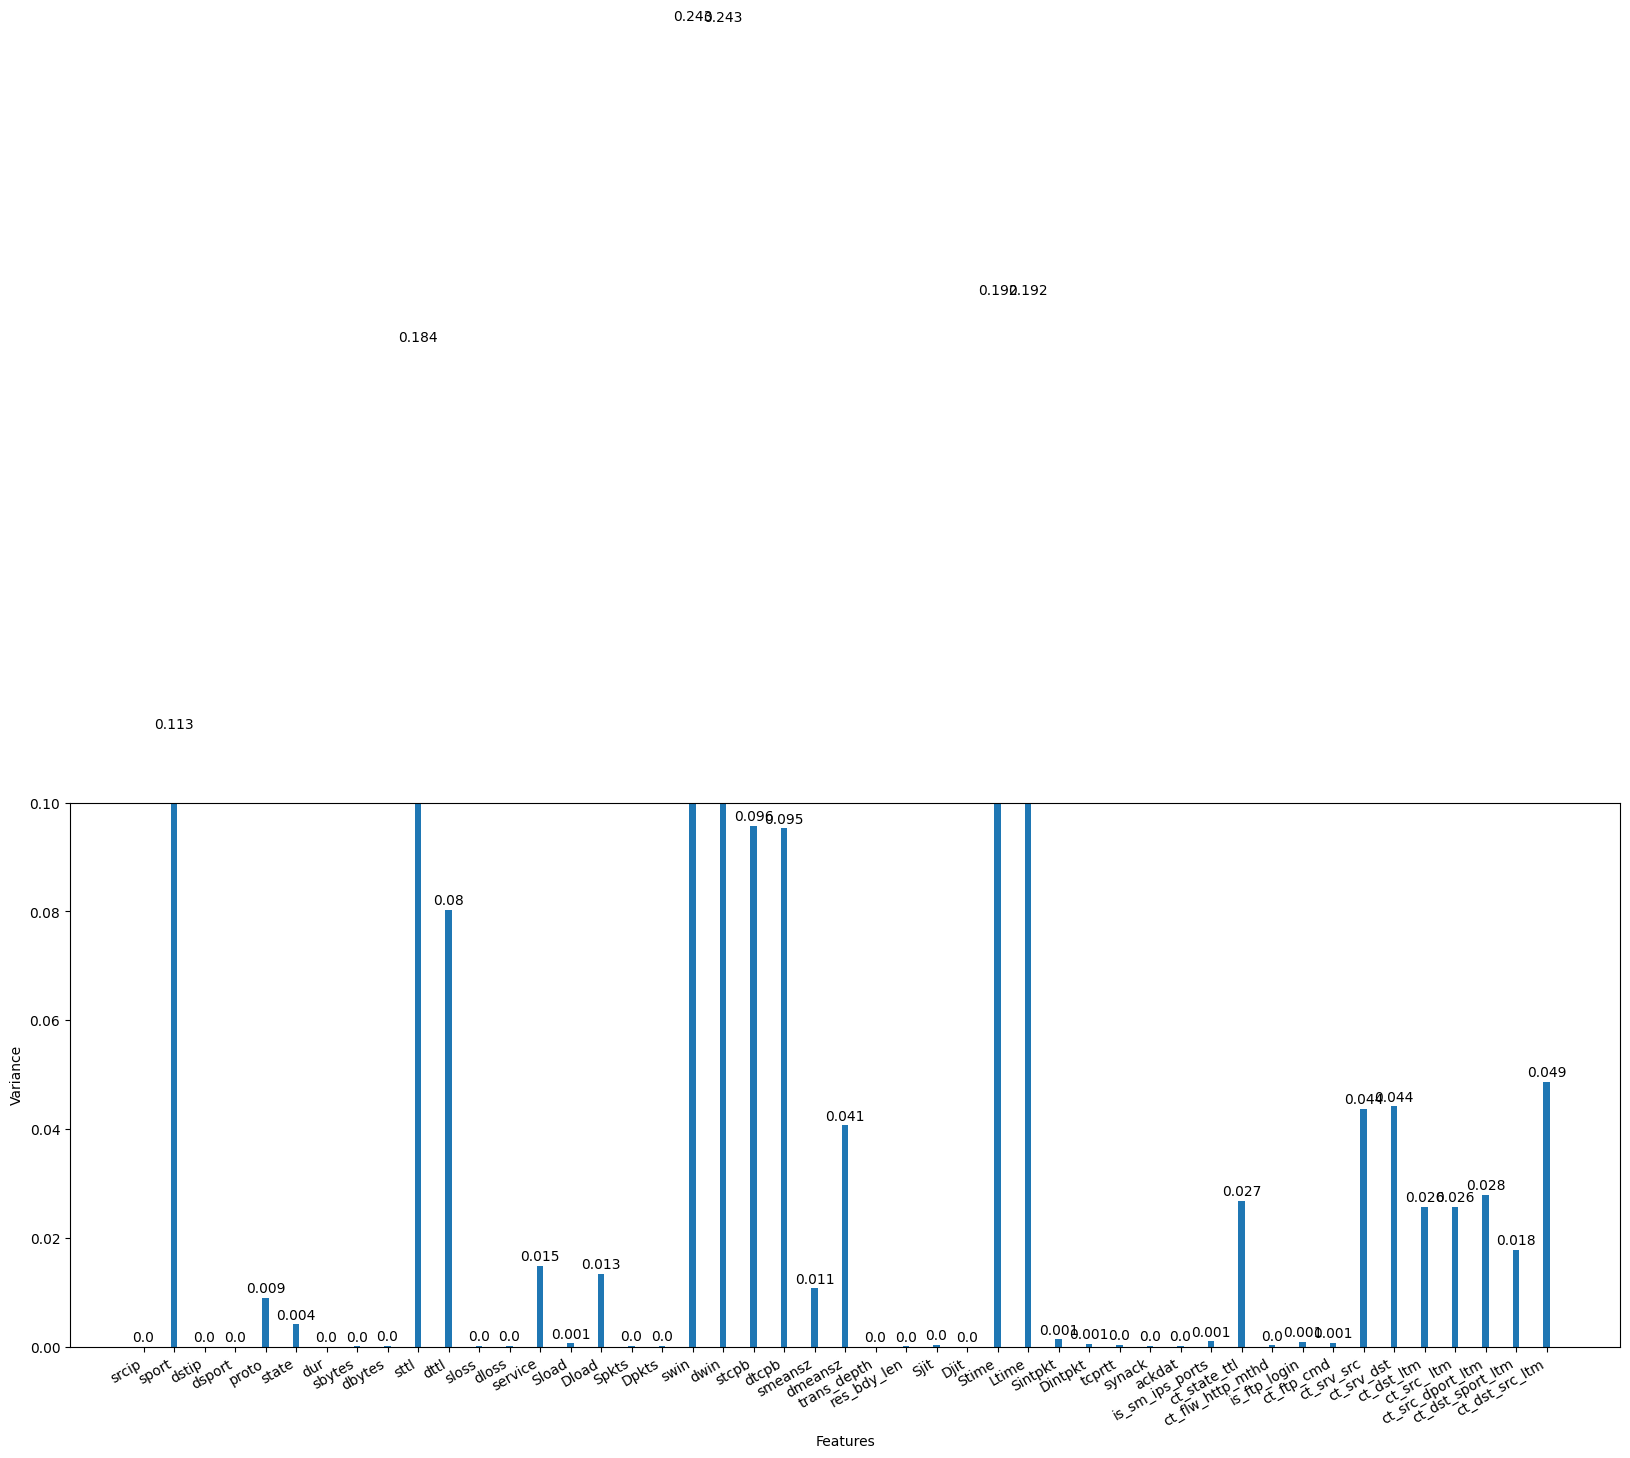

In [10]:
fig, ax = plt.subplots(figsize=(20, 8))

x = X.columns
y = scaled_X_train_v1.var(axis=0)

ax.bar(x, y, width=0.2)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.set_ylim(0, 0.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.001, s=str(round(value, 3)), ha='center')

fig.autofmt_xdate()
# plt.tight_layout()

In [11]:
# Set threshold to 0.09
drop_features = [ 'srcip', 'sport', 'dstip', 'dsport',
            'proto', 'state', 'dur', 'sbytes',
            'dbytes', 'sloss', 'dloss', 'service',
            'Sload', 'Dload', 'Spkts', 'Dpkts', 'smeansz', 'dmeansz',
            'trans_depth', 'res_bdy_len', 'Sjit', 'Djit',
            'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat',
            'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd',
            'is_ftp_login',	'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst',
            'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm',
            'ct_dst_sport_ltm',	'ct_dst_src_ltm']

sel_X_train_v1 = X_train_v1.drop(drop_features, axis=1)
sel_X_test_v1 = X_test_v1.drop(drop_features, axis=1)

gbc.fit(sel_X_train_v1, y_train_v1)

var_preds = gbc.predict(sel_X_test_v1)

f1_score_var = round(f1_score(y_test_v1, var_preds, average='weighted'), 3)

print(f1_score_var)

0.992


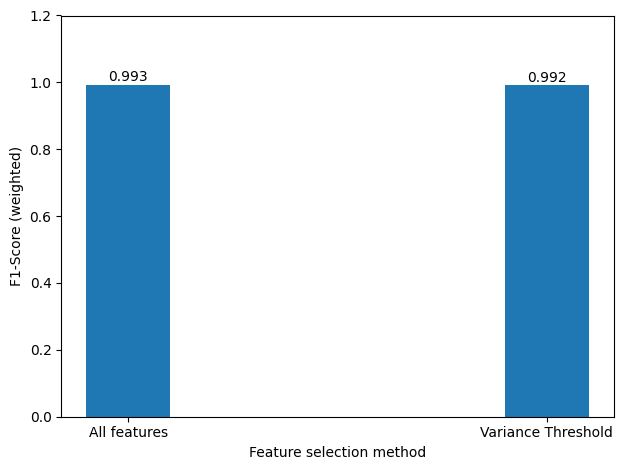

In [12]:
fix, ax = plt.subplots()
x = ['All features', 'Variance Threshold']
y = [f1_score_all, f1_score_var]

ax.bar(x, y, width=0.2)
ax.set_xlabel('Feature selection method')
ax.set_ylabel('F1-Score (weighted)')
ax.set_ylim(0, 1.2)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.01, s=str(round(value, 3)), ha='center')


plt.tight_layout()